# Introduction to Numpy powered by oneAPI


A really excellent descriptipon of broadcasting is given by Jake Van Der Plas at PyCon 2017:

[Losing your Loops Fast Numerical Computing with NumPy](https://www.youtube.com/watch?v=EEUXKG97YRw)

### Learning Objectives:
- Describe what broadcasting and fancy slicing are
- Apply these techniques to acheive remarkable speedups via oneMKL vectorization.


# Exercises:

Do a page search for each **Exercise** in this notebook. Complete All exercises. Code in cells above each exercise may give insight into a solid approach

In [1]:
import numpy as np
from math import log10 as lg10
import time
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline

# Numpy Broadcasting

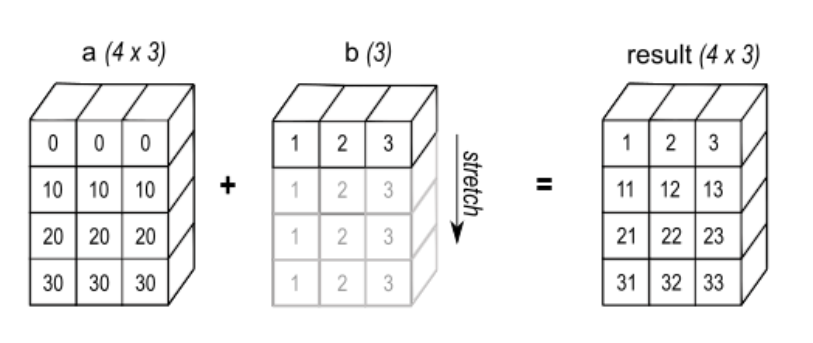


"The term **broadcasting** describes how numpy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes."

In a **Linear Algebra class** there is no such notion at broadcasting

In Linear Algebra:
- Two matrices can be added or subtracted ONLY if their dimensions are exactly the same (lets say (both MxN)
- Two matrices can be multiplied ONLY if their inner dimensions are the same A(5,2) x B (2,7) = (5,7)

In Numpy, **broadcasting** is a way to speed up comptation by essentially making the dimensions the correct size by copying data from the smaller dimension until the resulting array is suitable for Linear Algebra addition or multiplication.

The one exception: Outer product is the same in linear Algebra and Numpy, at least in the case of (Nx1) x (1xN) = (NxN)

[Broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html) SciPy.org

### Broadcasting rules and conditions:

For a set of arrays can be considered ‘broadcastable’, if this set of conditions that are met.

1. The shape of the arrays are the same or the ending dimensions for both arrays match

1. If an array has a different number of dimension to the another array, then the array with the lesser dimension is extended by 1 until the number of dimension of both arrays are equal

1. If two arrays are to be broadcastable, then the array with dimension size of 1 is to behave in a manner that enables the array with lesser dimension to be expanded by duplication to the length of the second array.  (eg. a (3,1) is promoted to (3,3) by copying to fill dimension

For better intuition about broadcasting - watch this excellent presentation by:
[Jake Vanderplas **Losing your Loops Fast Numerical Computing with NumPy**](https://www.youtube.com/watch?v=EEUXKG97YRw).

In [2]:
# Condition 1: The shape of the arrays are the same or the ending dimensions for both arrays match
x = np.array([3,2,1])
y = np.array([6,5,2])
z = x * y
print("x.shape is", x.shape)

print("y.shape is", y.shape)

print("x.shape == y.shape:",x.shape == y.shape)

print("x: ",z)

x.shape is (3,)
y.shape is (3,)
x.shape == y.shape: True
x:  [18 10  2]


In [3]:
A = np.array([[0,0,0],[10,10,10],[20,20,20],[30,30,30]])
A

array([[ 0,  0,  0],
       [10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [4]:
B = np.array([1,2,3,4,]).reshape(4,1)
A+B

array([[ 1,  1,  1],
       [12, 12, 12],
       [23, 23, 23],
       [34, 34, 34]])

In [5]:
# Condition 2
x = np.array([3,2,1,2,6,4,5,7,9]).reshape(3,3)
y = np.array([6,5,2]) # has shape (3,) a single dimension

print("x.shape: ",x.shape)
print("x: \n",x)

print("y.shape: \n", y.shape)
print("y: \n",y)
print("y.shape extended by one internally (3,1)\n")

z = x * y  # y has a simension added to be 3,1, then filled out by copy to be 3,3
print("z: \n", z)
# multiplies element by element in a row by row fashion, 
# [3,2,1] x [6,5,2] =[18,10,2]

x.shape:  (3, 3)
x: 
 [[3 2 1]
 [2 6 4]
 [5 7 9]]
y.shape: 
 (3,)
y: 
 [6 5 2]
y.shape extended by one internally (3,1)

z: 
 [[18 10  2]
 [12 30  8]
 [30 35 18]]


In [6]:
# The array 'x' has a length of 6 and the array 'y' has length of 1, 
# by following condition 3, the array 'y' has been stretched 6 times 
# to match the array 'x' during broadcasting.

x = np.array([3,2,1,2,6,4]*3).reshape(6,3)
print("x: \n", x)

y = np.array([6,5,2]).reshape(1,3)  # has shape (1,3) a single dimension
print("y: \n", y)

print("len(x)", len(x))

print("len(y)", len(y))

print("x + y\n", x + y) # adds y to each row of X


x: 
 [[3 2 1]
 [2 6 4]
 [3 2 1]
 [2 6 4]
 [3 2 1]
 [2 6 4]]
y: 
 [[6 5 2]]
len(x) 6
len(y) 1
x + y
 [[ 9  7  3]
 [ 8 11  6]
 [ 9  7  3]
 [ 8 11  6]
 [ 9  7  3]
 [ 8 11  6]]


In AI we use this sometime to normalize data - subtract the mean from an array, then divide by the standard deviation

## Example of normalizing California housing dataset

This example combines Numpy **Aggregations** with **Broadcasting**

But the **Numpy vectorized** code is **MUCH more readable** and easier to debug and explain

Here's how the broadcasting works here for the Standardization method:
- X is two dimensional array
- X.mean(axis = 0) is a vector (1,3)
- X.std(axis = 0) is a vector (1,3)
- both small vectors (1,3) are broadcast up to the dimension of X (3,3)
- in Linear algebra class you have to add/subtract arrays of same dimensions A is two dimensional array

Note: the scikit-learn stardarize is about 2x faster that these methods. Always look to use optimized libraries such as these in defeerence to your own loops but ALSO in deference to your own Numpy rolled one liners - but let performance and readability be your guide here.


In [7]:
from sklearn.datasets import fetch_california_housing
import numpy as np
california_housing = fetch_california_housing(as_frame=True)
X = california_housing.data.to_numpy()

def standardizeLoop(X): # about 15 lines of code, more to go wrong
    C = X.shape[-1]
    L = len(X)
    tmp = np.zeros(X.shape)

    for col in range(C):
        mean = 0
        total = 0
        for row in range(len(X)):
            total += X[row, col]
        mean = total/L
        diff2 = 0
        for row in range(L):
            d = X[row,col] - mean
            diff2 += d*d
            tmp[row, col] = X[row, col] - mean
        for row in range(L):
            tmp[row, col] = tmp[row, col]/np.sqrt(diff2/(L))
    return tmp

def standardize(A): # one line of code
#     A is two dimensional array
#     A.mean(axis = 0) is a vector (1,3)
#     A.std(axis = 0) is a vector (1,3)
#     both scalars are broadcast up to the dimension of A (3,3)
#     in Linear algebra Class you have to add/subtract arrays of same dimensions
    #return (A - A.mean(axis=0))/A.std(axis=0)
    return (A - np.mean(A, axis=0))/np.std(A, axis=0)

print("standardize Loop")
print(standardizeLoop(X))

print("standardize NumPy")
print(standardize(X))


standardize Loop
[[ 2.34476576  0.98214266  0.62855945 ... -0.04959654  1.05254828
  -1.32783522]
 [ 2.33223796 -0.60701891  0.32704136 ... -0.09251223  1.04318455
  -1.32284391]
 [ 1.7826994   1.85618152  1.15562047 ... -0.02584253  1.03850269
  -1.33282653]
 ...
 [-1.14259331 -0.92485123 -0.09031802 ... -0.0717345   1.77823747
  -0.8237132 ]
 [-1.05458292 -0.84539315 -0.04021111 ... -0.09122515  1.77823747
  -0.87362627]
 [-0.78012947 -1.00430931 -0.07044252 ... -0.04368215  1.75014627
  -0.83369581]]
standardize NumPy
[[ 2.34476576  0.98214266  0.62855945 ... -0.04959654  1.05254828
  -1.32783522]
 [ 2.33223796 -0.60701891  0.32704136 ... -0.09251223  1.04318455
  -1.32284391]
 [ 1.7826994   1.85618152  1.15562047 ... -0.02584253  1.03850269
  -1.33282653]
 ...
 [-1.14259331 -0.92485123 -0.09031802 ... -0.0717345   1.77823747
  -0.8237132 ]
 [-1.05458292 -0.84539315 -0.04021111 ... -0.09122515  1.77823747
  -0.87362627]
 [-0.78012947 -1.00430931 -0.07044252 ... -0.04368215  1.750146

In [8]:
import time
timing = {}
t1 = time.time()
standardizeLoop(X)
timing['loop'] = time.time() -t1

t1 = time.time()
standardize(X)
timing['numpy'] = time.time() -t1
print(timing)
print(f"Acceleration {timing['loop']/timing['numpy']:4.1f} X")

{'loop': 0.48389506340026855, 'numpy': 0.004298686981201172}
Acceleration 112.6 X


## Exercise:

Use broadcasting to create a 10x10 array containing the multiplication table for the numbers 1 to 10

#### Hint:

- multiply a **(10,1)** vector by a **(1,10)** vector - this is an **outer product**
- think reshape
- search engine ;-)
- Hint: 
```
A.reshape(10,1) * A
```

# Exercise: Perform an outer product using broadcasting

This cell will error - fix the error

- Hint:

```python
A.reshape(10,1) * A
```

In [9]:
A = np.arange(1, 11)
print(A)
##### insert single line numpy code below ####

A.reshape(10,1) * A

##############################################

[ 1  2  3  4  5  6  7  8  9 10]


array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
       [  2,   4,   6,   8,  10,  12,  14,  16,  18,  20],
       [  3,   6,   9,  12,  15,  18,  21,  24,  27,  30],
       [  4,   8,  12,  16,  20,  24,  28,  32,  36,  40],
       [  5,  10,  15,  20,  25,  30,  35,  40,  45,  50],
       [  6,  12,  18,  24,  30,  36,  42,  48,  54,  60],
       [  7,  14,  21,  28,  35,  42,  49,  56,  63,  70],
       [  8,  16,  24,  32,  40,  48,  56,  64,  72,  80],
       [  9,  18,  27,  36,  45,  54,  63,  72,  81,  90],
       [ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]])

### Naive loop outer product

In [10]:
N = 10_000
timing = {}
A = np.arange(0, N)
t1 = time.time()
B = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = (i+1)*(j+1)
t2 = time.time()
loop = t2-t1
timing['loop'] = loop
print("Elapsed ", t2-t1)

Elapsed  43.036941051483154


### Numpy Broadcast outer product

Hint:

```python
B = A.reshape(N,1) * A
```

In [11]:
t1 = time.time()
##### insert single line numpy code below ####

B = A.reshape(N,1) * A

##############################################
t2 = time.time()
broadcast = t2 - t1
print("Elapsed ", t2-t1)
timing['broadcast'] = broadcast
print("Numpy Broadcast Acceleration: ", loop/broadcast)

Elapsed  0.47377705574035645
Numpy Broadcast Acceleration:  90.83795960577002


### Plot speedup for Broadcasting

Speedup   91 X


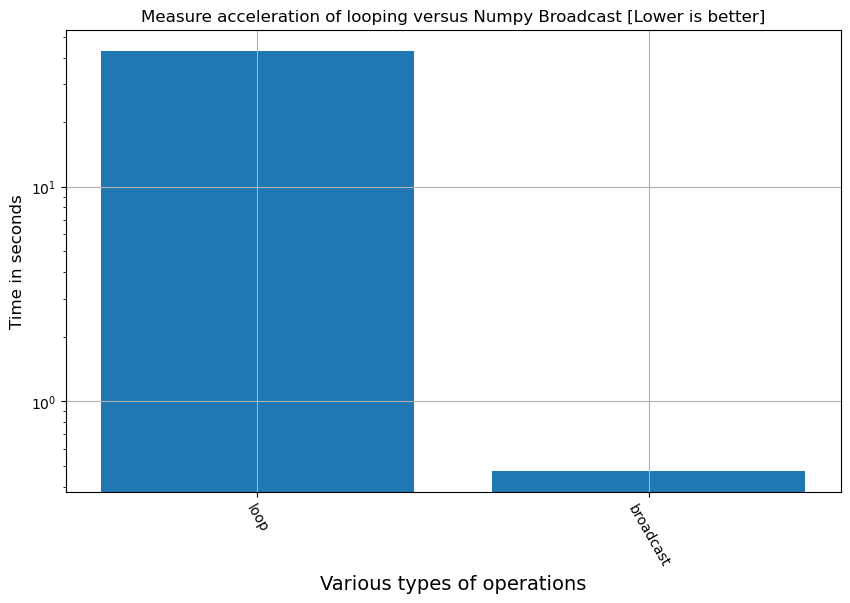

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Measure acceleration of looping versus Numpy Broadcast [Lower is better]",fontsize=12)
plt.ylabel("Time in seconds",fontsize=12)
plt.yscale('log')
plt.xlabel("Various types of operations",fontsize=14)
plt.grid(True)
plt.xticks(rotation = -60)
plt.bar(x = list(timing.keys()), height= list(timing.values()), align='center',tick_label=list(timing.keys()))
print("Speedup {:4.0f} X".format( timing['loop']/timing['broadcast']))

In [13]:
print("Done")

Done
